# Ruble Volatility Project — Part 3: Time Series Modeling

This notebook continues the Ruble Volatility Project...

In this notebook ...

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import VAR

from sklearn.metrics import mean_squared_error

import warnings
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.filterwarnings("ignore", category=ValueWarning)
warnings.filterwarnings("ignore")
from stargazer.stargazer import Stargazer

### I. Loading data

In [4]:
data = pd.read_csv("/Users/zlatavorobeva/Documents/GitHub/Ruble_Volatility_Prediction/data/Full_Ruble_Monthly_Data.csv")
data.tail()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/zlatavorobeva/Documents/GitHub/Ruble_Volatility_Prediction/data/Full_Ruble_Monthly_Data.csv'

### 3. GARCH

In [ ]:
data_work["log_rub"] = np.log(data_work["RUB"])
data_work["ret_rub"] = data_work["log_rub"].diff().dropna()

In [361]:
from arch import arch_model

In [362]:
# Drop NaN after differencing
returns = data_work["ret_rub"].dropna()

# GARCH(1,1) with normal distribution
garch_model = arch_model(returns, vol="GARCH", p=1, q=1, dist="normal")
garch_res = garch_model.fit(disp="off")

print(garch_res.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                ret_rub   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                665.663
Distribution:                  Normal   AIC:                          -1323.33
Method:            Maximum Likelihood   BIC:                          -1307.39
                                        No. Observations:                  397
Date:                Wed, Sep 17 2025   Df Residuals:                      396
Time:                        20:48:37   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -5.0168e-03  3.115e-03     -1.611      0.

/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.004705. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Forecasted variances: [0.00130918 0.00187604 0.00235315 0.0027547  0.00309267 0.00337713
 0.00361654 0.00381804 0.00398763 0.00413037 0.0042505  0.00435162]


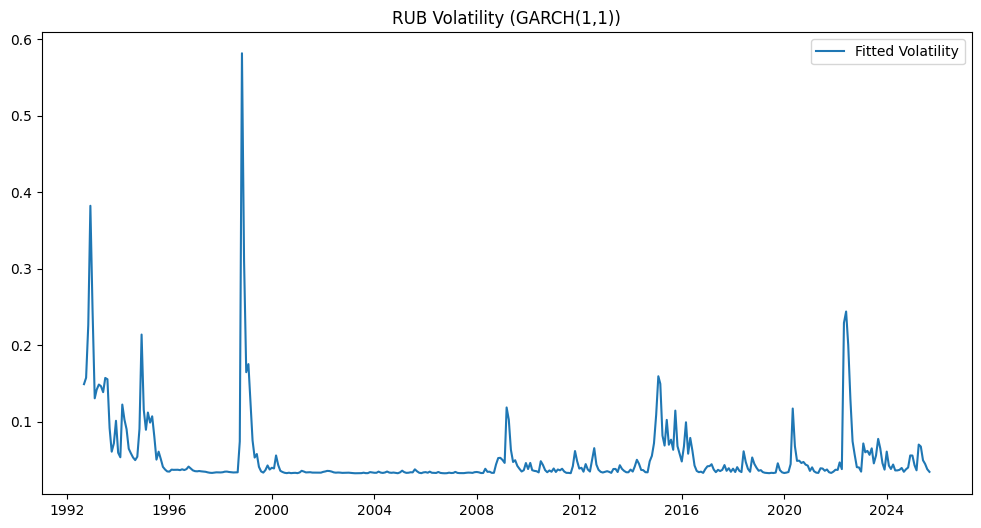

In [363]:
# Forecast next 12 months volatility
garch_forecast = garch_res.forecast(horizon=12)

# Extract conditional variance forecast
vol_forecast = garch_forecast.variance.values[-1, :]
print("Forecasted variances:", vol_forecast)

# Plot conditional volatility
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(garch_res.conditional_volatility, label="Fitted Volatility")
plt.title("RUB Volatility (GARCH(1,1))")
plt.legend()
plt.show()

/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -621.195
Distribution:                  Normal   AIC:                           1250.39
Method:            Maximum Likelihood   BIC:                           1266.34
                                        No. Observations:                  398
Date:                Wed, Sep 17 2025   Df Residuals:                      397
Time:                        20:50:32   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1066  3.469e-02      3.074  2.113e-03 [3.864e-0

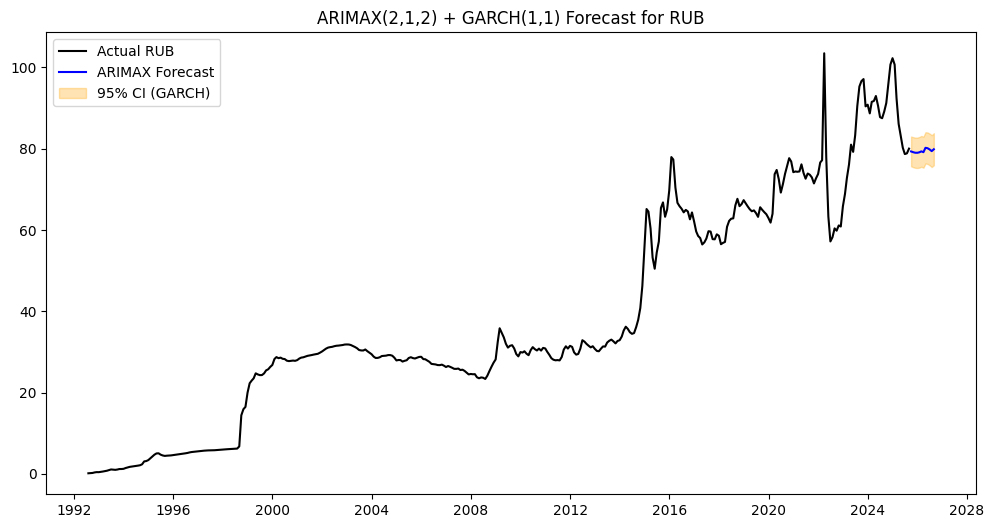

In [364]:
# --- 1. Fit ARIMAX(2,1,2) with exogenous variables ---
exog_all = data_work[[
    "Brent_price", "FD_investment", "GDP_per_capita",
    "shock_1998_default", "shock_2008_gfc",
    "shock_2014_crimea", "shock_2020_covid", "shock_2022_invasion"
]]

arimax_model = sm.tsa.ARIMA(
    endog=data_work["RUB"],
    exog=exog_all,
    order=(2,1,2),
    trend='n'
)
arimax_res = arimax_model.fit()

# --- 2. Extract residuals from ARIMAX ---
residuals = arimax_res.resid

# --- 3. Fit GARCH(1,1) on residuals ---
garch_model = arch_model(residuals, vol="GARCH", p=1, q=1, dist="normal")
garch_res = garch_model.fit(disp="off")

print(garch_res.summary())

# --- 4. Forecast volatility ---
garch_forecast = garch_res.forecast(horizon=12)
vol_forecast = np.sqrt(garch_forecast.variance.values[-1, :])  # standard deviation

# --- 5. Forecast mean RUB (from ARIMAX) ---
steps = 12
exog_future = exog_all.tail(steps)  # replace with your future exog
arimax_forecast = arimax_res.get_forecast(steps=steps, exog=exog_future)
mean_forecast = arimax_forecast.predicted_mean

# --- 6. Combine mean + volatility bands ---
upper = mean_forecast + 1.96 * vol_forecast
lower = mean_forecast - 1.96 * vol_forecast

plt.figure(figsize=(12,6))
plt.plot(data_work.index, data_work["RUB"], label="Actual RUB", color="black")
plt.plot(mean_forecast.index, mean_forecast, label="ARIMAX Forecast", color="blue")
plt.fill_between(mean_forecast.index, lower, upper, color="orange", alpha=0.3, label="95% CI (GARCH)")
plt.legend()
plt.title("ARIMAX(2,1,2) + GARCH(1,1) Forecast for RUB")
plt.show()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1934.371, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1926.577, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1926.124, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1934.371, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1928.099, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1928.040, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1925.939, Time=0.04 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1917.836, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1923.314, Time=0.04 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1923.909, Time=0.04 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1923.925, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1922.040, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1921.917, Time=0.05 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1925.887, Time=0.10 sec
 ARIMA(2,1,2)(0,0,0)[0]          

/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


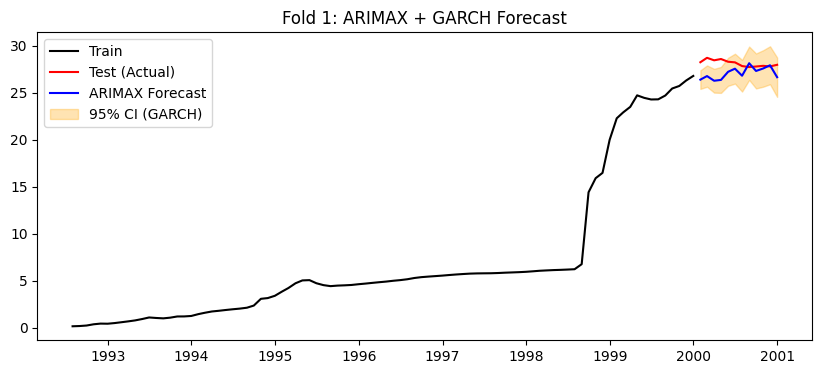

/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


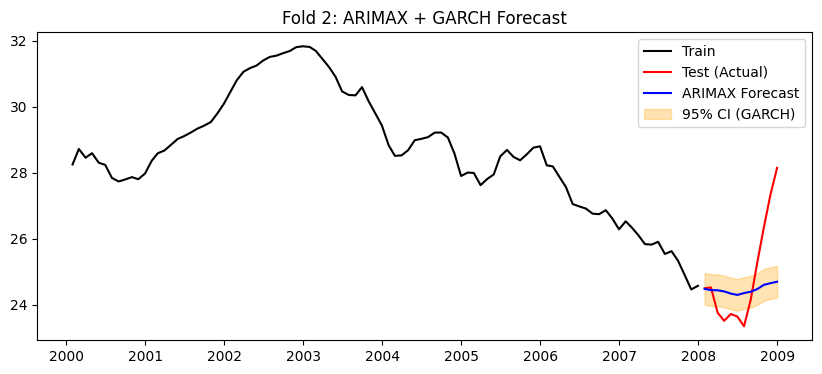

/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


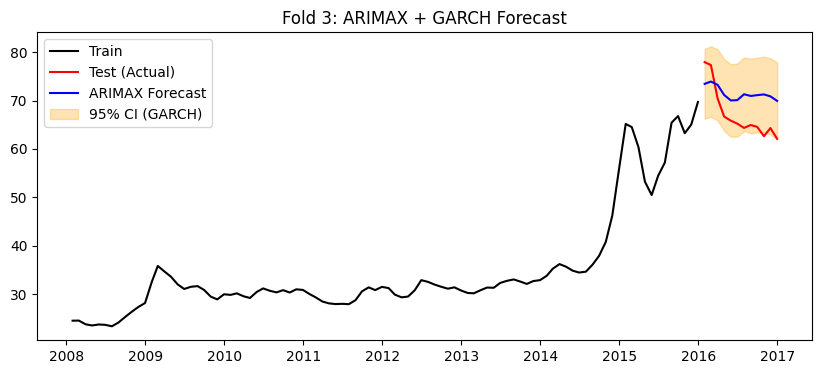

/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


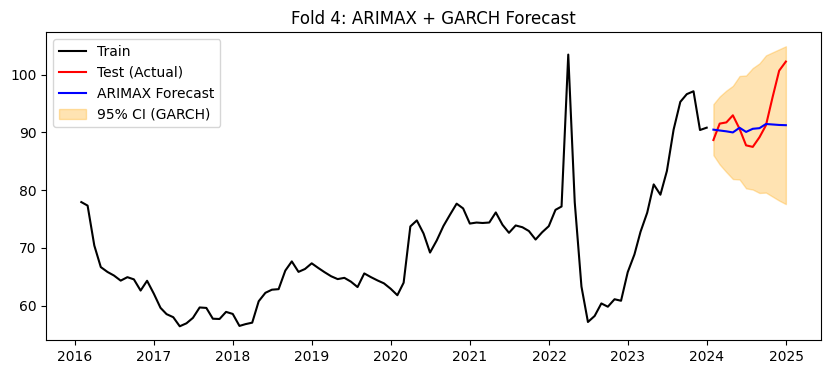

Cross-validated RMSE (ARIMAX+GARCH): 3.338107231557277


In [ ]:

# ======================
# 1. Setup exogenous
# ======================
exog_all = data_work[[
    "Brent_price", "FD_investment", "GDP_per_capita",
    "shock_1998_default", "shock_2008_gfc",
    "shock_2014_crimea", "shock_2020_covid", "shock_2022_invasion"
]]

# ======================
# 2. Auto-ARIMAX to get best order
# ======================
model_4 = auto_arima(
    y=data_work["RUB"], 
    exogenous=exog_all,
    start_p=0, max_p=5,
    start_q=0, max_q=5,
    d=None,
    seasonal=False,      
    stepwise=True,
    trace=True,
    trend='n'
)

best_order = model_4.order
print("Best ARIMAX order:", best_order)

# ======================
# 3. Cross-validation with ARIMAX + GARCH
# ======================
rmse_folds = []

for i in range(1, 5):
    # ---- Train/Test split
    train_mask = data_work[f"train{i}"]
    test_mask  = data_work[f"test{i}"]

    y_train = data_work.loc[train_mask, "RUB"].sort_index()
    y_test  = data_work.loc[test_mask, "RUB"].sort_index()

    exog_train = exog_all.loc[train_mask].sort_index()
    exog_test  = exog_all.loc[test_mask].sort_index()

    # ---- Step 1: Fit ARIMAX
    model_cv = ARIMA(endog=y_train, exog=exog_train, order=best_order, trend='n').fit()

    # ---- Step 2: Get residuals & fit GARCH
    residuals = model_cv.resid
    garch = arch_model(residuals, vol="GARCH", p=1, q=1)
    garch_fit = garch.fit(disp="off")

    # ---- Step 3: Forecast ARIMAX mean
    phat_mean = model_cv.forecast(steps=len(y_test), exog=exog_test)

    # ---- Step 4: Forecast GARCH volatility (optional, CI bands)
    garch_forecast = garch_fit.forecast(horizon=len(y_test))
    vol_forecast = np.sqrt(garch_forecast.variance.values[-1, :])

    # ---- Step 5: Evaluate RMSE (using mean only)
    err_sq = (y_test.values - phat_mean.values) ** 2
    rmse = np.sqrt(np.mean(err_sq))
    rmse_folds.append(rmse)

    # ---- Optional Plot per fold
    plt.figure(figsize=(10,4))
    plt.plot(y_train.index, y_train, label="Train", color="black")
    plt.plot(y_test.index, y_test, label="Test (Actual)", color="red")
    plt.plot(y_test.index, phat_mean, label="ARIMAX Forecast", color="blue")
    plt.fill_between(y_test.index, phat_mean - 1.96*vol_forecast,
                     phat_mean + 1.96*vol_forecast, color="orange", alpha=0.3,
                     label="95% CI (GARCH)")
    plt.title(f"Fold {i}: ARIMAX + GARCH Forecast")
    plt.legend()
    plt.show()

# ======================
# 4. Final CV RMSE
# ======================
rmse_cv_arimax_garch = float(np.mean(rmse_folds))
print("Cross-validated RMSE (ARIMAX+GARCH):", rmse_cv_arimax_garch)

/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


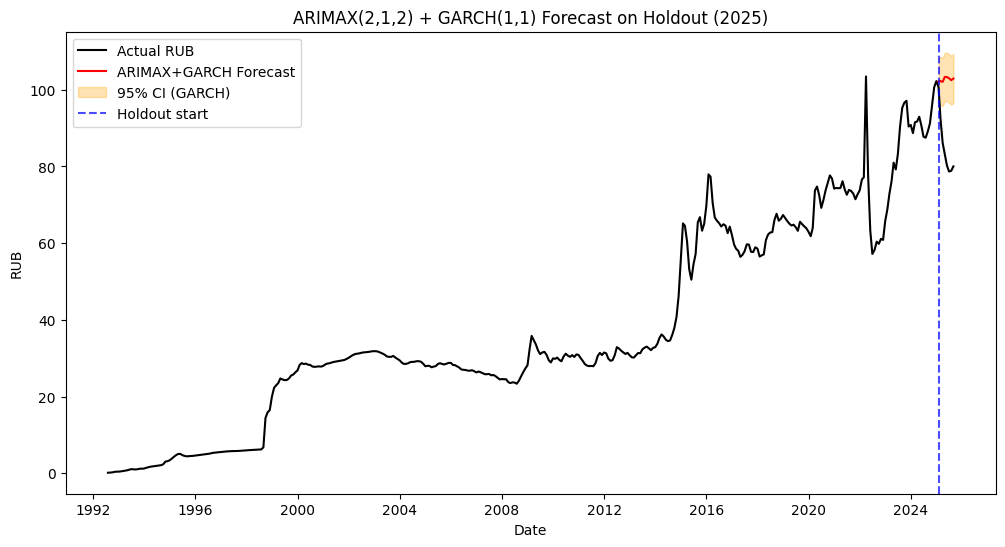

In [366]:
from arch import arch_model

# 1. Endogenous and exogenous split
y = data_work["RUB"]
exog_all = data_work[[
    "Brent_price", "FD_investment", "GDP_per_capita",
    "shock_1998_default", "shock_2008_gfc",
    "shock_2014_crimea", "shock_2020_covid", "shock_2022_invasion"
]]

y_train = y[~data_work["holdout"]]
exog_train = exog_all[~data_work["holdout"]]

y_holdout = y[data_work["holdout"]]
exog_holdout = exog_all[data_work["holdout"]]

# 2. Fit ARIMAX on training set
arimax_model = ARIMA(endog=y_train, exog=exog_train, order=(2,1,2), trend="n")
arimax_res = arimax_model.fit()

# 3. Take residuals from ARIMAX → fit GARCH(1,1)
residuals = arimax_res.resid
garch_model = arch_model(residuals, vol="GARCH", p=1, q=1, dist="normal")
garch_res = garch_model.fit(disp="off")

# 4. Forecast ARIMAX mean for holdout
steps = len(y_holdout)
arimax_forecast = arimax_res.get_forecast(steps=steps, exog=exog_holdout)
forecast_mean = arimax_forecast.predicted_mean

# 5. Forecast volatility from GARCH for the same horizon
garch_forecast = garch_res.forecast(horizon=steps)
vol_forecast = np.sqrt(garch_forecast.variance.values[-1, :])  # std dev

# 6. Build GARCH-based CI
upper = forecast_mean + 1.96 * vol_forecast
lower = forecast_mean - 1.96 * vol_forecast

# 7. Plot
plt.figure(figsize=(12,6))
plt.plot(y.index, y, label="Actual RUB", color="black")
plt.plot(y_holdout.index, forecast_mean, label="ARIMAX+GARCH Forecast", color="red")
plt.fill_between(y_holdout.index, lower, upper, color="orange", alpha=0.3, label="95% CI (GARCH)")
plt.axvline(y_holdout.index[0], color="blue", linestyle="--", alpha=0.7, label="Holdout start")
plt.title("ARIMAX(2,1,2) + GARCH(1,1) Forecast on Holdout (2025)")
plt.xlabel("Date")
plt.ylabel("RUB")
plt.legend()
plt.show()

### Anotehr Set Up for CV

In [375]:
data_work2 = data[data["year"] <= 2024].copy()

In [376]:
# Define CV blocks

cv_blocks = [
    (1992, 1998, 1999),
    (1999, 2006, 2007),
    (2007, 2014, 2015),
    (2015, 2022, 2023),
]

# Create train/test masks for each fold
for fold, (train_start, train_end, test_year) in enumerate(cv_blocks, start=1):
    data_work2[f"train{fold}"] = (data_work2["year"] >= train_start) & (data_work2["year"] <= train_end)
    data_work2[f"test{fold}"]  = data_work2["year"] == test_year

data_work2["holdout"] = data_work2["year"] == 2024

In [379]:
data_work2.columns

Index(['date', 'currency_rate', 'year', 'quarter', 'month', 'day', 'dow',
       'weekend', 'currency_rate_change', 'denomination', 'RUB',
       'GDP_per_capita', 'Brent_price', 'GDP_deflator', 'FD_investment',
       'Inflation', 'train1', 'test1', 'train2', 'test2', 'train3', 'test3',
       'train4', 'test4', 'holdout'],
      dtype='object')

In [382]:
# Make sure date column is datetime and set as index
data_work2["date"] = pd.to_datetime(data_work2["date"])
data_work2 = data_work2.set_index("date").asfreq("M")

# Define shocks by year-month ranges
shock_windows = {
    "shock_1998_default": ((1998, 8), (1998, 11)),
    "shock_2008_gfc": ((2008, 9), (2008, 12)),
    "shock_2014_crimea": ((2014, 3), (2014, 6)),
    "shock_2020_covid": ((2020, 3), (2020, 6)),
    "shock_2022_invasion": ((2022, 2), (2022, 5)),
}

# Add dummy variables for shocks
for shock_name, ((start_y, start_m), (end_y, end_m)) in shock_windows.items():
    mask = (
        ((data_work2.index.year > start_y) | ((data_work2.index.year == start_y) & (data_work2.index.month >= start_m)))
        & ((data_work2.index.year < end_y) | ((data_work2.index.year == end_y) & (data_work2.index.month <= end_m)))
    )
    data_work2[shock_name] = mask.astype(int)

# Quick check
print(data_work2[[c for c in data_work2.columns if "shock" in c]].sum())

shock_1998_default     4
shock_2008_gfc         4
shock_2014_crimea      4
shock_2020_covid       4
shock_2022_invasion    4
dtype: int64


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1885.995, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1881.285, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1880.788, Time=0.49 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1885.995, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1882.784, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1882.772, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1881.000, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1880.788, Time=0.04 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.933 seconds
Best ARIMAX order: (0, 1, 1)


/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


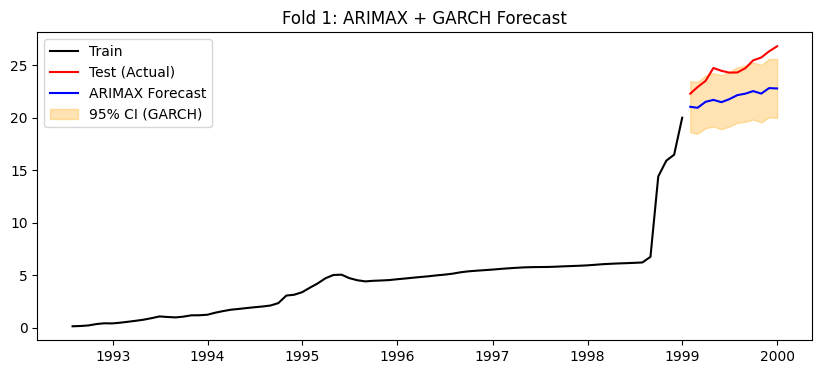

/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


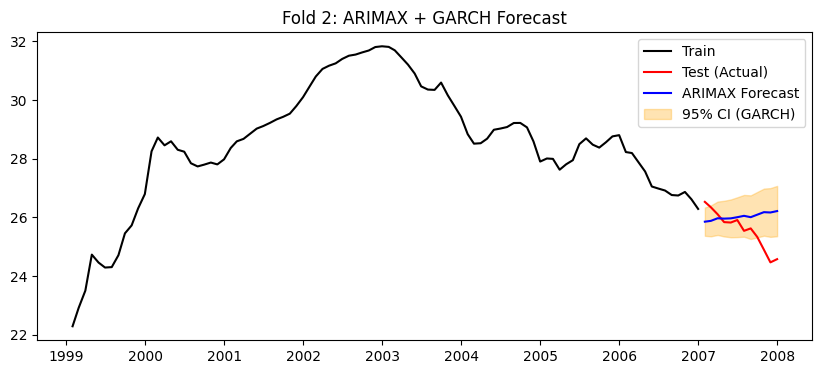

/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


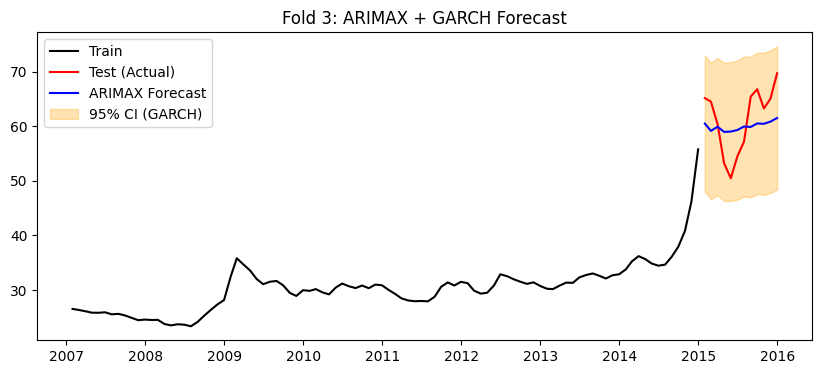

/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


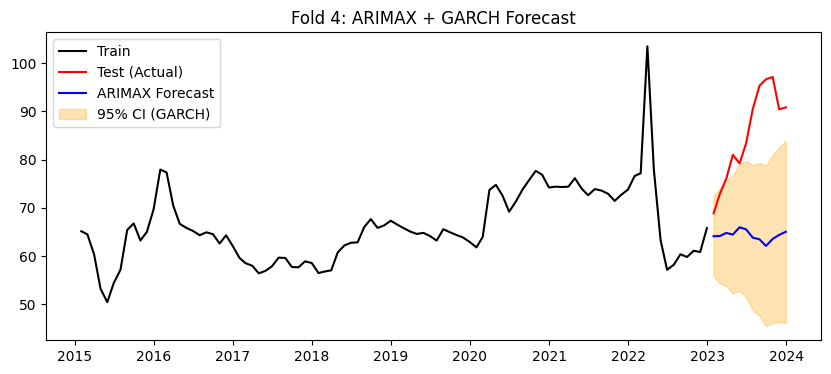

Cross-validated RMSE (ARIMAX+GARCH): 8.022831899903174


In [384]:
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from arch import arch_model
import numpy as np
import matplotlib.pyplot as plt

# ======================
# 1. Setup exogenous
# ======================
# Only use exogenous variables that exist in data_work2
exog_cols = [
    "Brent_price", "FD_investment", "GDP_per_capita",
    "shock_1998_default", "shock_2008_gfc",
    "shock_2014_crimea", "shock_2020_covid", "shock_2022_invasion"
]
exog_all = data_work2[[col for col in exog_cols if col in data_work2.columns]]

# ======================
# 2. Auto-ARIMAX to get best order
# ======================
model_4 = auto_arima(
    y=data_work2["RUB"], 
    exogenous=exog_all if not exog_all.empty else None,
    start_p=0, max_p=5,
    start_q=0, max_q=5,
    d=None,
    seasonal=False,      
    stepwise=True,
    trace=True,
    trend='n'
)

best_order = model_4.order
print("Best ARIMAX order:", best_order)

# ======================
# 3. Cross-validation with ARIMAX + GARCH
# ======================
rmse_folds = []

for i in range(1, 5):
    # ---- Train/Test split
    train_mask = data_work2[f"train{i}"]
    test_mask  = data_work2[f"test{i}"]

    y_train = data_work2.loc[train_mask, "RUB"].sort_index()
    y_test  = data_work2.loc[test_mask, "RUB"].sort_index()

    exog_train = exog_all.loc[train_mask].sort_index() if not exog_all.empty else None
    exog_test  = exog_all.loc[test_mask].sort_index() if not exog_all.empty else None

    # ---- Step 1: Fit ARIMAX
    try:
        model_cv = ARIMA(endog=y_train, exog=exog_train, order=best_order, trend='n').fit()
    except Exception as e:
        print(f"ARIMAX fit failed for fold {i}: {e}")
        rmse_folds.append(np.nan)
        continue

    # ---- Step 2: Get residuals & fit GARCH
    residuals = model_cv.resid
    try:
        garch = arch_model(residuals, vol="GARCH", p=1, q=1)
        garch_fit = garch.fit(disp="off")
    except Exception as e:
        print(f"GARCH fit failed for fold {i}: {e}")
        rmse_folds.append(np.nan)
        continue

    # ---- Step 3: Forecast ARIMAX mean
    try:
        phat_mean = model_cv.forecast(steps=len(y_test), exog=exog_test)
    except Exception as e:
        print(f"ARIMAX forecast failed for fold {i}: {e}")
        rmse_folds.append(np.nan)
        continue

    # ---- Step 4: Forecast GARCH volatility (optional, CI bands)
    try:
        garch_forecast = garch_fit.forecast(horizon=len(y_test))
        vol_forecast = np.sqrt(garch_forecast.variance.values[-1, :])
    except Exception as e:
        print(f"GARCH forecast failed for fold {i}: {e}")
        vol_forecast = np.zeros(len(y_test))

    # ---- Step 5: Evaluate RMSE (using mean only)
    err_sq = (y_test.values - phat_mean.values) ** 2
    rmse = np.sqrt(np.mean(err_sq))
    rmse_folds.append(rmse)

    # ---- Optional Plot per fold
    plt.figure(figsize=(10,4))
    plt.plot(y_train.index, y_train, label="Train", color="black")
    plt.plot(y_test.index, y_test, label="Test (Actual)", color="red")
    plt.plot(y_test.index, phat_mean, label="ARIMAX Forecast", color="blue")
    plt.fill_between(y_test.index, phat_mean - 1.96*vol_forecast,
                     phat_mean + 1.96*vol_forecast, color="orange", alpha=0.3,
                     label="95% CI (GARCH)")
    plt.title(f"Fold {i}: ARIMAX + GARCH Forecast")
    plt.legend()
    plt.show()

# ======================
# 4. Final CV RMSE
# ======================
rmse_cv_arimax_garch = float(np.nanmean(rmse_folds))
print("Cross-validated RMSE (ARIMAX+GARCH):", rmse_cv_arimax_garch)

/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


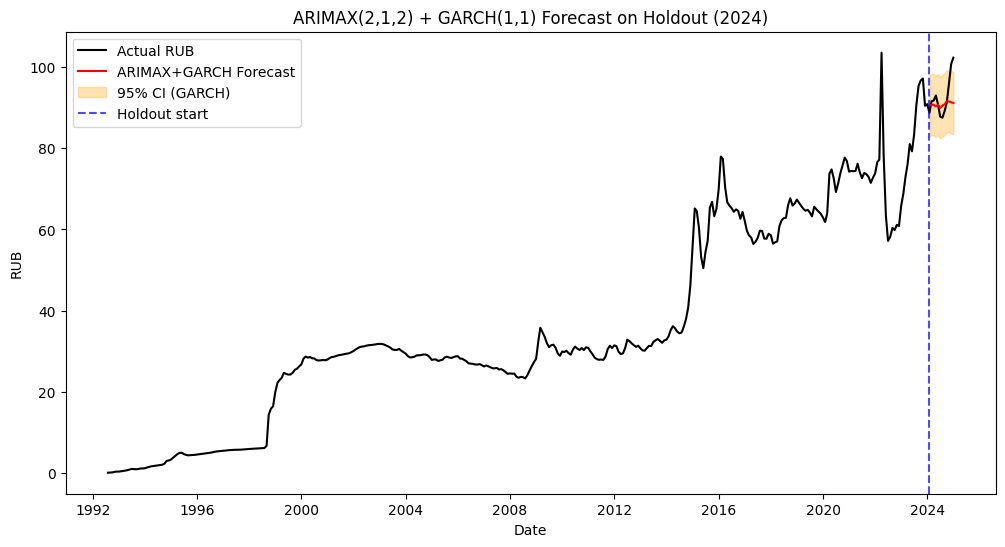

In [ ]:
# 1. Endogenous and exogenous split
y = data_work2["RUB"]
exog_all = data_work2[[
    "Brent_price", "FD_investment", "GDP_per_capita",
    "shock_1998_default", "shock_2008_gfc",
    "shock_2014_crimea", "shock_2020_covid", "shock_2022_invasion"
]]

y_train = y[~data_work2["holdout"]]
exog_train = exog_all2[~data_work2["holdout"]]

y_holdout = y[data_work2["holdout"]]
exog_holdout = exog_all[data_work2["holdout"]]

# 2. Fit ARIMAX on training set
arimax_model = ARIMA(endog=y_train, exog=exog_train, order=(2,1,2), trend="n")
arimax_res = arimax_model.fit()

# 3. Take residuals from ARIMAX → fit GARCH(1,1)
residuals = arimax_res.resid
garch_model = arch_model(residuals, vol="GARCH", p=1, q=1, dist="normal")
garch_res = garch_model.fit(disp="off")

# 4. Forecast ARIMAX mean for holdout
steps = len(y_holdout)
arimax_forecast = arimax_res.get_forecast(steps=steps, exog=exog_holdout)
forecast_mean = arimax_forecast.predicted_mean

# 5. Forecast volatility from GARCH for the same horizon
garch_forecast = garch_res.forecast(horizon=steps)
vol_forecast = np.sqrt(garch_forecast.variance.values[-1, :])  # std dev

# 6. Build GARCH-based CI
upper = forecast_mean + 1.96 * vol_forecast
lower = forecast_mean - 1.96 * vol_forecast

# 7. Plot
plt.figure(figsize=(12,6))
plt.plot(y.index, y, label="Actual RUB", color="black")
plt.plot(y_holdout.index, forecast_mean, label="ARIMAX+GARCH Forecast", color="red")
plt.fill_between(y_holdout.index, lower, upper, color="orange", alpha=0.3, label="95% CI (GARCH)")
plt.axvline(y_holdout.index[0], color="blue", linestyle="--", alpha=0.7, label="Holdout start")
plt.title("ARIMAX(2,1,2) + GARCH(1,1) Forecast on Holdout (2025)")
plt.xlabel("Date")
plt.ylabel("RUB")
plt.legend()
plt.show()

/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


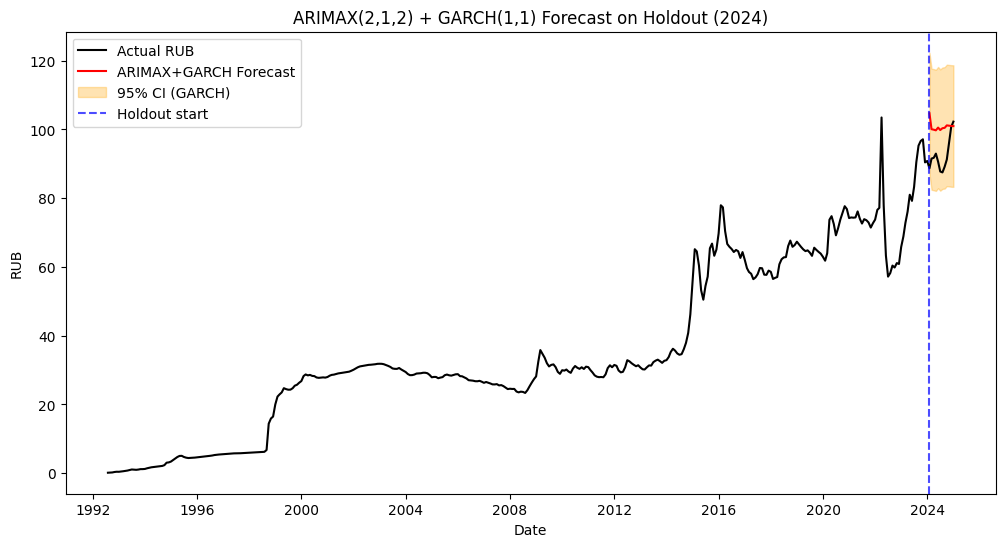

In [ ]:
from arch import arch_model

# 1. Endogenous and exogenous split
y = data_work2["RUB"]

# Only use exogenous variables that exist in the dataframe
exog_cols = [col for col in [
    "Brent_price", "FD_investment",
    "shock_1998_default", "shock_2008_gfc",
    "shock_2014_crimea", "shock_2020_covid", "shock_2022_invasion"
] if col in data_work2.columns]
exog_all = data_work2[exog_cols]

y_train = y[~data_work2["holdout"]]
exog_train = exog_all[~data_work2["holdout"]]

y_holdout = y[data_work2["holdout"]]
exog_holdout = exog_all[data_work2["holdout"]]

# 2. Fit ARIMAX on training set
arimax_model = ARIMA(endog=y_train, exog=exog_train, order=(2,1,2), trend="n")
arimax_res = arimax_model.fit()

# 3. Take residuals from ARIMAX → fit GARCH(1,1)
residuals = arimax_res.resid
garch_model = arch_model(residuals, vol="GARCH", p=1, q=1, dist="normal")
garch_res = garch_model.fit(disp="off")

# 4. Forecast ARIMAX mean for holdout
steps = len(y_holdout)
arimax_forecast = arimax_res.get_forecast(steps=steps, exog=exog_holdout)
forecast_mean = arimax_forecast.predicted_mean

# 5. Forecast volatility from GARCH for the same horizon
garch_forecast = garch_res.forecast(horizon=steps)
vol_forecast = np.sqrt(garch_forecast.variance.values[-1, :])  # std dev

# 6. Build GARCH-based CI
upper = forecast_mean + 1.96 * vol_forecast
lower = forecast_mean - 1.96 * vol_forecast

# 7. Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(y.index, y, label="Actual RUB", color="black")
plt.plot(y_holdout.index, forecast_mean, label="ARIMAX+GARCH Forecast", color="red")
plt.fill_between(y_holdout.index, lower, upper, color="orange", alpha=0.3, label="95% CI (GARCH)")
plt.axvline(y_holdout.index[0], color="blue", linestyle="--", alpha=0.7, label="Holdout start")
plt.title("ARIMAX(2,1,2) + GARCH(1,1) Forecast on Holdout (2024)")
plt.xlabel("Date")
plt.ylabel("RUB")
plt.legend()
plt.show()

In [ ]:

import pandas as pd
import numpy as np
# --- Create lag features for RUB ---
max_lag = 12  # use up to 12 months of lags
for lag in range(1, max_lag+1):
    data_work2[f"RUB_lag{lag}"] = data_work2["RUB"].shift(lag)

# --- Optionally add rolling features ---
data_work2["RUB_roll3"] = data_work2["RUB"].rolling(window=3).mean()
data_work2["RUB_roll6"] = data_work2["RUB"].rolling(window=6).mean()

# --- Define target and features ---
y = data_work2["RUB"]
exog_cols = [col for col in [
    "Brent_price", "FD_investment",
    "shock_1998_default", "shock_2008_gfc",
    "shock_2014_crimea", "shock_2020_covid", "shock_2022_invasion"
] if col in data_work2.columns]

X = data_work2[[f"RUB_lag{i}" for i in range(1, max_lag+1)] + exog_cols + ["RUB_roll3", "RUB_roll6"]]

In [392]:
X_train = X[~data_work2["holdout"]].dropna()
y_train = y.loc[X_train.index]

X_holdout = X[data_work2["holdout"]].dropna()
y_holdout = y.loc[X_holdout.index]

In [396]:
!pip install xgboost

python(45645) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
500025.96s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 41.6 MB/s  0:00:00


In [408]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np

# 1. Convert to DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_holdout, label=y_holdout)

# 2. Params
params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "eta": 0.05,
    "max_depth": 5,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "seed": 42
}

# 3. Train with early stopping
watchlist = [(dtrain, "train"), (dvalid, "valid")]
xgb_model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=500,
    evals=watchlist,
    early_stopping_rounds=50,
    verbose_eval=False
)

# 4. Predict on holdout
y_pred = xgb_model.predict(dvalid)

# 5. RMSE
rmse = np.sqrt(mean_squared_error(y_holdout, y_pred))
print(f"Holdout RMSE: {rmse:.3f}")

Holdout RMSE: 5.013


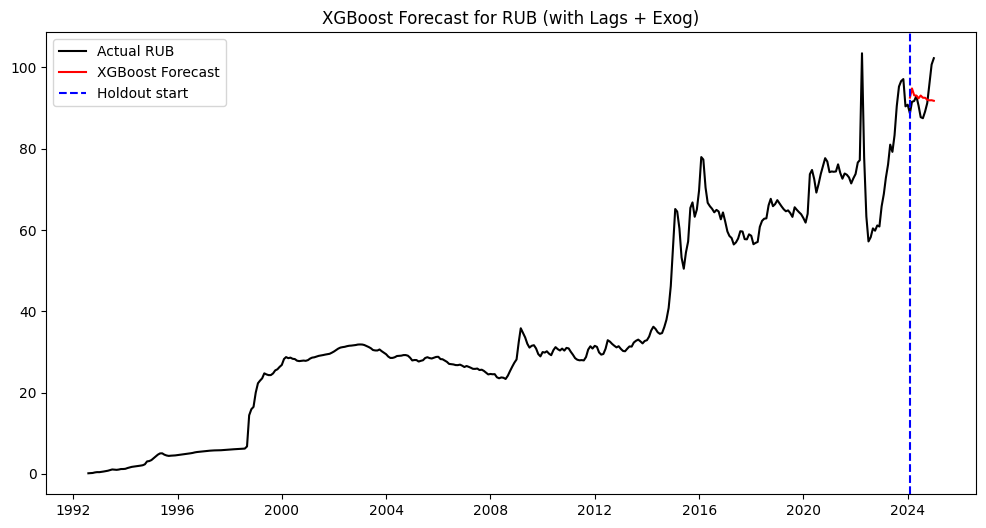

In [409]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(y.index, y, label="Actual RUB", color="black")
plt.plot(y_holdout.index, y_pred, label="XGBoost Forecast", color="red")
plt.axvline(y_holdout.index[0], color="blue", linestyle="--", label="Holdout start")
plt.title("XGBoost Forecast for RUB (with Lags + Exog)")
plt.legend()
plt.show()

CV RMSE (per fold): [1.476464370192401, 1.0044087307042429, 5.740794321572475, 5.9258655730818335]
Average CV RMSE: 3.5368832488877375


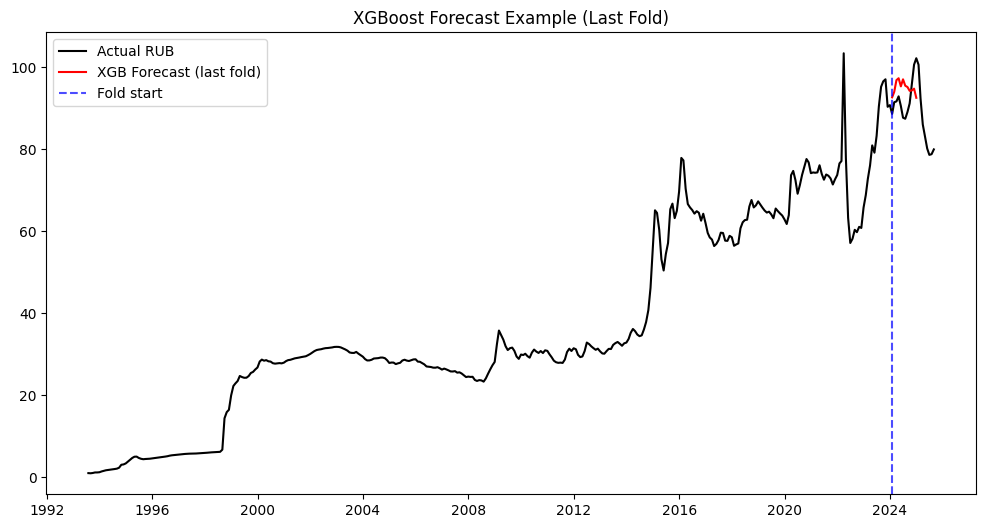

Holdout RMSE: 6.242


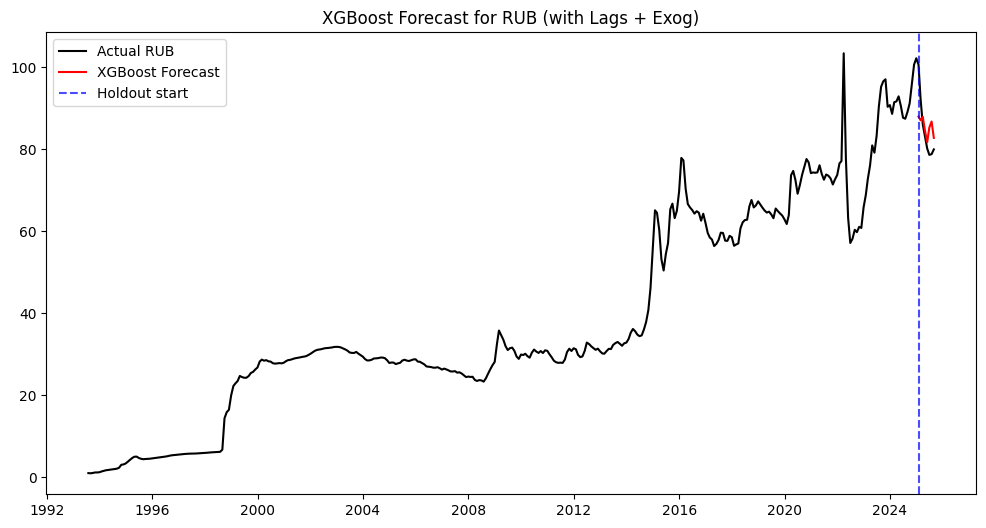

In [410]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# -------------------------------
# 1. Feature engineering
# -------------------------------
df = data_work.copy()

# Lags
for lag in [1, 2, 3, 6, 12]:
    df[f"RUB_lag{lag}"] = df["RUB"].shift(lag)

# Rolling mean/std
df["RUB_roll_mean3"] = df["RUB"].shift(1).rolling(3).mean()
df["RUB_roll_std3"]  = df["RUB"].shift(1).rolling(3).std()

# Time features
df["month"] = df.index.month
df["quarter"] = df.index.quarter
df["year"] = df.index.year

# Exogenous variables (already in your dataset)
exog_cols = [
    "Brent_price", "FD_investment", "GDP_per_capita",
    "shock_1998_default", "shock_2008_gfc",
    "shock_2014_crimea", "shock_2020_covid", "shock_2022_invasion"
]

feature_cols = [c for c in df.columns if "RUB_lag" in c or "RUB_roll" in c] + exog_cols + ["month","quarter","year"]

# Drop NA from lagging
df = df.dropna()

# -------------------------------
# 2. Walk-forward CV
# -------------------------------
rmse_folds = []
fold_forecasts = []

for i in range(1, 5):
    train_mask = df[f"train{i}"]
    test_mask  = df[f"test{i}"]

    X_train, y_train = df.loc[train_mask, feature_cols], df.loc[train_mask, "RUB"]
    X_test,  y_test  = df.loc[test_mask, feature_cols], df.loc[test_mask, "RUB"]

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest  = xgb.DMatrix(X_test, label=y_test)

    params = {
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "eta": 0.05,
        "max_depth": 5,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "seed": 42
    }

    # Train
    xgb_model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=500,
        evals=[(dtrain, "train"), (dtest, "valid")],
        early_stopping_rounds=50,
        verbose_eval=False
    )

    # Forecast
    y_pred = xgb_model.predict(dtest)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_folds.append(rmse)

    fold_forecasts.append((y_test.index, y_test, y_pred))

print("CV RMSE (per fold):", rmse_folds)
print("Average CV RMSE:", np.mean(rmse_folds))

# -------------------------------
# 3. Plot one fold example
# -------------------------------
plt.figure(figsize=(12,6))
idx, actual, pred = fold_forecasts[-1]  # last fold
plt.plot(df.index, df["RUB"], color="black", label="Actual RUB")
plt.plot(idx, pred, color="red", label="XGB Forecast (last fold)")
plt.axvline(idx[0], color="blue", linestyle="--", alpha=0.7, label="Fold start")
plt.legend()
plt.title("XGBoost Forecast Example (Last Fold)")
plt.show()

# -------------------------------
# 4. Final model on training + holdout forecast
# -------------------------------
y = df["RUB"]
X = df[feature_cols]

y_train = y[~df["holdout"]]
X_train = X[~df["holdout"]]
y_holdout = y[df["holdout"]]
X_holdout = X[df["holdout"]]

dtrain = xgb.DMatrix(X_train, label=y_train)
dhold  = xgb.DMatrix(X_holdout, label=y_holdout)

final_model = xgb.train(params=params, dtrain=dtrain, num_boost_round=500)
y_pred_holdout = final_model.predict(dhold)

rmse_holdout = np.sqrt(mean_squared_error(y_holdout, y_pred_holdout))
print(f"Holdout RMSE: {rmse_holdout:.3f}")

# Plot holdout forecast
plt.figure(figsize=(12,6))
plt.plot(y.index, y, label="Actual RUB", color="black")
plt.plot(y_holdout.index, y_pred_holdout, label="XGBoost Forecast", color="red")
plt.axvline(y_holdout.index[0], color="blue", linestyle="--", alpha=0.7, label="Holdout start")
plt.legend()
plt.title("XGBoost Forecast for RUB (with Lags + Exog)")
plt.show()